This file accomplishes the following broad objectives:

    1.) Tunes and compares the performance of different classifiers on the sarcasm data.
    2.) Modifies the best-performing model of the sarcasm data to maximize model performance under three hypothetical business scenarios
    3.) Explores the utility of using the sarcasm model to complement a sentiment analysis involving novel data
    

In [4]:
# Imports
from platform import python_version
import OOP_pickle_util
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix as confusion_matrix
import pandas as pd
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
plt.style.use("ggplot")
from Preprocessor import Preprocessor
import warnings; warnings.simplefilter('ignore')
from sklearn.linear_model import LogisticRegressionCV
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sinua\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sinua\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sinua\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Guppy and Heapy from 'Preprocessor.py' Partition of a set of 1071408 objects. Total size = 170717336 bytes.
 Index  Count   %     Size   % Cumulative  % Kind (class / dict of class)
     0    298   0 47414660  28  47414660  28 numpy.ndarray
     1 386342  36 42197017  25  89611677  52 str
     2 228553  21 18218672  11 107830349  63 tuple
     3 100515   9  8024811   5 115855160  68 bytes
     4  51457   5  7450872   4 123306032  72 types.CodeType
     5  20283   2  7374536   4 130680568  77 dict (no owner)
     6  46803   4  6365208   4 137045776  80 function
     7   5702   1  5743328   3 142789104  84 type
     8      9   0  3493880   2 146282984  86 spacy.lookups.Table
     9   2402   0  3486976   2 149769960  88 dict of module
<1821 more rows. Type e.g. '_.more' to view.>


In [5]:
# Check the current python version
print(python_version())

3.7.6


In [6]:
# load the preprocessor instance including attributes, most importantly the preprocessed DF containing the ...
#...full sarcasm training data
# this approach can lead to confusion regarding which data set is pickled

pre_inst_s = OOP_pickle_util.load_preprocessor_instance('preprocessor_instance_pickled') 
            

In [7]:
# This cell can be used as an alternative to unpickling (above)
# Instantiate an instance of the preprocessor and call the 'tweet_format' method on the entire sarcasm training dataset. This approach might be more...
#...time-consuming than calling the preprocessor in Ipython or the console
# this approach is preferable because it avoids potential confusion between datasets and pickling/unpickling the incorrect dataset
# currently no working - the preprocessor instance called is not the latest version

#prepro_inst_sarc = Preprocessor('all_sarc_and_matching_tweets.csv')

# Call the 'tweet_format' method of the preprocessor in order to preprocess the sarcasm dataset
#prepro_inst_sarc.tweet_format()


In [8]:
# Verify attributes of the preprocessor instance for the preprocessed sarcasm data including the preprocessed DF

pre_inst_s.__dict__.keys()


dict_keys(['tweet_data', 'lemmatizer', 'stop_words', 'nlp', 'df'])

In [9]:
# Inspect the df attribute of the preprocessor instance for the preprocessed sarcasm data

pre_inst_s.df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 48662 entries, 0 to 209876
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   political_score  48662 non-null  float64
 1   text33           48662 non-null  object 
 2   tweet_cat        48662 non-null  int64  
 3   original_tweet   48662 non-null  object 
 4   text34           48662 non-null  object 
 5   text35           48662 non-null  object 
 6   text36           48662 non-null  int64  
 7   text_final       48662 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 3.3+ MB


In [10]:
# Assign the preprocessor df containing the full sarcasm training data

df = pre_inst_s.df

# Check the working df
df.head(2)


,political_score,text33,tweet_cat,original_tweet,text34,text35,text36,text_final
0,0.488090,deep state dems continue attack machine anything stop,1,b'RT @TribulationThe: Deep State Dems continue to ATTACK EACH OTHER! BUST OUT POPCORN!!! \xf0\...,"[deep, state, dems, continue, attack, machine, anything, stop]","[deep, state, dems, continue, attack, machine, anything, stop]",8,deep state dems continue attack machine anything stop
7,0.359033,would see would ban stay h,1,"b'RT @TribulationThe: Only in Leftist, Kommie Kalifornia, would you see such HATRED such as this...","[would, see, would, ban, stay, h]","[would, see, would, ban, stay]",5,would see would ban stay


In [11]:
# Show the counts in each category of 'tweet_cat' - the number of tweets categorized as 'sarcastic' (ones) or non-sarcastic (zeroes)

df.tweet_cat.value_counts()


1    28220
0    20442
Name: tweet_cat, dtype: int64

In [12]:
# Create the feature and target arrays for modeling the sarcasm training data using classifier algorithms

# Create the feature array
X = df.text_final

# Create the target array 
y = df['tweet_cat'].values.astype(np.int) 


In [13]:
# Split the sarcasm data's target and feature arrays into training and testing splits

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
# Vectorize the training and test feature array splits

# Instantiate CountVectorizer
vectorizer = CountVectorizer()

# learn the vocabulary and create a document-term matrix (DTM)/sparse array for the training split features of the sarcasm data
# Reassign the training features
X_train = vectorizer.fit_transform(X_train)

# Create a document-term matrix based on the training data DTM/sparse array for the test split features of the sarcasm data
# Reassign the testing features
X_test = vectorizer.transform(X_test)
           

In [15]:
# Model selection and model tuning
# Function for executing classifier algorithms, outputing performance metrics and the best hyperparameters for each classifier

def evaluate_model(X_test, y_test, clf, parameters):
    
    print("Name of classifier: ",clf)
    
    # Instantiate an instance of GridsearchCV
    grid = GridSearchCV(clf, parameters, n_jobs = -1, scoring = 'roc_auc')
    
    # Fit the gridsearch model to the training splits - the DTM/sparse array and the target 
    grid_search = grid.fit(X_train, y_train)
    
    # Make predictions for X_test DTM/sparse array based on the best parameters.The refitted GridSearchCV estimator...
    #....is made available as the best_estimator_ attribute and permits using predict ...
    #...directly on this GridSearchCV instance. Predict produces binary classifications predictions 
    y_pred = grid_search.predict(X_test)
    
    # Create a confusion matrix comparing the test target values with the predicted values
    cm = metrics.confusion_matrix(y_test, y_pred)
    
    # Print the best score based on the scoring method, in this case 'roc_auc'
    # Mean cross-validated score of the best_estimator
    print("Best ROC AUC score:", grid_search.best_score_) 
    
    # Print a classification report for the best model
    print(classification_report(y_test, y_pred))
    print('\nConfusion Matrix:\n', cm)

    # Print the best parameters identified by gridsearching
    print("Best Parameters:", grid_search.best_params_)
    
# Reference: https://github.com/sdesaidata/Springboard/blob/master/Capstone2_TweetsandMusic_Predictor/5__MachineLearning.ipynb
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
    

In [16]:
# Classifier algorithms for testing and their respective hyperparameter search grids
# Commented-out the search grid for random forest classisfier due to long processing time

# Algorithms to compare
MNB = MultinomialNB()
LR = LogisticRegression()
LSVC = LinearSVC()
RF = RandomForestClassifier()

# Search grids for classifier-specific parameters
algos_params ={MNB:{'alpha':[0.01, 0.05, 0.1, 0.15, 0.25, 0.5, 1, 1.5, 2.5, 5, 7.5, 10, 15, 50]}, 
               LR:{'C': [0.001, 0.1, 1, 10, 100]},
               LSVC:{'C': [0.001, 0.1, 1, 10, 100]}}
             # RF:{'n_estimators': [100, 300, 500, 800, 1200], # comment out RF due to long processing time (~ 3 hours)
             #    'max_depth': [5, 8, 15, 25, 30], # comment out RF due to long processing time (~ 3 hours)
             #    'min_samples_split': [2, 5, 10, 15, 100], # comment out RF due to long processing time (~ 3 hours)
             #    'min_samples_leaf': [1, 2, 5, 10]},} # comment out RF due to long processing time (~ 3 hours)
              

In [17]:
# Compare the performance of classifier algorithms by iteratively calling the 'evaluate_model' function on all the ...
#...classifier algorithms except random forest classifier due to lengthy process time
# Call the random forest classifier separately (below)

for k, v in algos_params.items():evaluate_model(X_test, y_test, k, v)
    

Name of classifier:  MultinomialNB()
Best ROC AUC score: 0.8392361640270842
              precision    recall  f1-score   support

           0       0.70      0.77      0.73      4100
           1       0.82      0.77      0.79      5633

    accuracy                           0.77      9733
   macro avg       0.76      0.77      0.76      9733
weighted avg       0.77      0.77      0.77      9733


Confusion Matrix:
 [[3147  953]
 [1323 4310]]
Best Parameters: {'alpha': 0.15}
Name of classifier:  LogisticRegression()
Best ROC AUC score: 0.870196286427471
              precision    recall  f1-score   support

           0       0.74      0.77      0.76      4100
           1       0.83      0.81      0.82      5633

    accuracy                           0.79      9733
   macro avg       0.79      0.79      0.79      9733
weighted avg       0.79      0.79      0.79      9733


Confusion Matrix:
 [[3160  940]
 [1096 4537]]
Best Parameters: {'C': 1}
Name of classifier:  LinearSVC()
Best

#### Random Forest Classifier

In [18]:
# CAUTION: LONG PROCESSING TIME

# Run random forest separately due to long processing time (~ 3 hours)

# Instantiate a RandomForestClassifier instance
RF = RandomForestClassifier()

n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(RF, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1, scoring = 'roc_auc')

# Fit the gridsearch model
RF_search = gridF.fit(X_train, y_train)

# Make predictions for Xtest based on the best parameters.The refitted GridSearchCV estimator...
#....is made available at the best_estimator_ attribute and permits using predict ...
#...directly on this GridSearchCV instance.
y_pred = RF_search.predict(X_test)
    
# Confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)

# Print the best score based on the scoring method, in this case 'roc_auc'
# Mean cross-validated score of the best_estimator
print("Best ROC AUC score:",RF_search.best_score_) 
    
print(classification_report(y_test, y_pred))
print('\nConfusion Matrix:\n', cm)

# Print the best parameters
print("Best Parameters:", RF_search.best_params_)

# Reference: https://towardsdatascience.com/optimizing-hyperparameters-in-random-forest-classification-ec7741f9d3f6


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   59.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 35.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 83.9min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 121.0min finished


Best ROC AUC score: 0.837639955761713
              precision    recall  f1-score   support

           0       0.89      0.17      0.28      4100
           1       0.62      0.98      0.76      5633

    accuracy                           0.64      9733
   macro avg       0.75      0.57      0.52      9733
weighted avg       0.73      0.64      0.56      9733


Confusion Matrix:
 [[ 678 3422]
 [  88 5545]]
Best Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1200}


In [19]:
# Classfication metrics for the random forest classifier

# Print the best score for the random forest classifier based on the scoring method, in this case 'roc_auc'
print("Best ROC AUC score:",RF_search.best_score_) 
    
print(classification_report(y_test, y_pred))
print('\nConfusion Matrix:\n', cm)

# Print the best parameters
print("Best Parameters:", RF_search.best_params_)


Best ROC AUC score: 0.837639955761713
              precision    recall  f1-score   support

           0       0.89      0.17      0.28      4100
           1       0.62      0.98      0.76      5633

    accuracy                           0.64      9733
   macro avg       0.75      0.57      0.52      9733
weighted avg       0.73      0.64      0.56      9733


Confusion Matrix:
 [[ 678 3422]
 [  88 5545]]
Best Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1200}


In [20]:
# Fit the classifiers using the best parameters identified by gridsearching
# Produce roc curves and calculate roc scores for each classifier

LR = LogisticRegression(C = 1)
LR.fit(X_train, y_train)
LR_probs = LR.predict_proba(X_test)
LR_probs = LR_probs[:, 1]
LR_fpr, LR_tpr, LR_thresholds = roc_curve(y_test, LR_probs)
LR_auc = roc_auc_score(y_test, LR_probs)
print('Logistic Regression AUC: %.4f' % LR_auc)

MNB = MultinomialNB(alpha = 0.15)
MNB.fit(X_train, y_train)
MNB_probs = MNB.predict_proba(X_test)
MNB_probs = MNB_probs[:, 1]
MNB_fpr, MNB_tpr, MNB_thresholds = roc_curve(y_test, MNB_probs)
MNB_auc = roc_auc_score(y_test, MNB_probs)
print('Multinomial naive Bayes AUC: %.4f' % MNB_auc)

LSVC = LinearSVC(C = 0.1)
LSVC.fit(X_train, y_train)
LSVC_probs = LSVC.decision_function(X_test)
#LSVC_probs = LSVC_probs[:, 1]
LSVC_fpr, LSVC_tpr, LSVC_thresholds = roc_curve(y_test, LSVC_probs)
LSVC_auc = roc_auc_score(y_test, LSVC_probs)
print('Linear Support Vector Classifier AUC: %.4f' % LSVC_auc)

RF = RandomForestClassifier(max_depth = 30, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 1200)
RF.fit(X_train, y_train)
RF_probs = RF.predict_proba(X_test)
RF_probs = RF_probs[:, 1]
RF_fpr, RF_tpr, RF_thresholds = roc_curve(y_test, RF_probs)
RF_auc = roc_auc_score(y_test, RF_probs)
print('Random Forest Classifier AUC: %.4f' % RF_auc)

Logistic Regression AUC: 0.8764
Multinomial naive Bayes AUC: 0.8460
Linear Support Vector Classifier AUC: 0.8752
Random Forest Classifier AUC: 0.8479


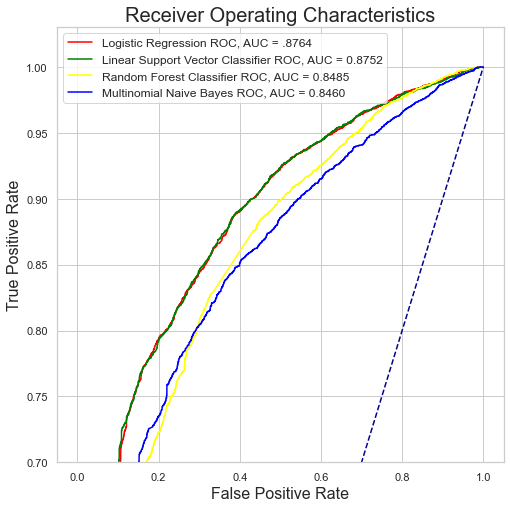

In [21]:
# Plot the roc curves for each classifier using their best hyperparameters

sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.plot(LR_fpr, LR_tpr, color='red', label='Logistic Regression ROC, AUC = .8764')
plt.plot(LSVC_fpr, LSVC_tpr, color='green', label='Linear Support Vector Classifier ROC, AUC = 0.8752')
plt.plot(RF_fpr, RF_tpr, color='yellow', label='Random Forest Classifier ROC, AUC = 0.8485')
plt.plot(MNB_fpr, MNB_tpr, color='blue', label='Multinomial Naive Bayes ROC, AUC = 0.8460')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.title("Receiver Operating Characteristics", fontsize = 20)
plt.legend(loc='best', fontsize  = 12)
plt.xlabel("False Positive Rate", fontsize = 16)
plt.ylabel("True Positive Rate", fontsize = 16)
plt.ylim(0.7,1.03)
plt.savefig('capstone2_roc_auc.png')

# Reference: # https://stackabuse.com/understanding-roc-curves-with-python/


### Classification Predictions

#### Classification Metrics for the Logistic Regression Model of the Sarcasm Data for Discriminating Between Sarcastic and Non-sarcastic Tweets

In [22]:
# Use the best model - logistic regression(C=1) to make classification predictions from the test features for the sarcasm data

# Predict binary classifications for each tweet in the test features
LR_y_pred_binary = LR.predict(X_test)

# Create probabilities of each tweet being sarcastic
LR_y_pred = LR.predict_proba(X_test)[:,1]


In [23]:
# Metrics for the best model - logistic regression (C=1)

# Accuracy
print('Accuracy: %.3f' % accuracy_score(y_true= y_test, y_pred = LR_y_pred_binary))
# Precision
print('Precision: %.3f' % precision_score(y_true= y_test, y_pred = LR_y_pred_binary))
# Recall
print('Recall: %.3f' % recall_score(y_true= y_test, y_pred = LR_y_pred_binary))
# F1 score
print('F1 Score: %.3f' % f1_score(y_true= y_test, y_pred = LR_y_pred_binary))


Accuracy: 0.791
Precision: 0.828
Recall: 0.805
F1 Score: 0.817


In [24]:
# Generate performance metrics using a classification report for the logistic regression for the sarcasm data

report_LR = classification_report(y_test, LR_y_pred_binary,output_dict=True)
# Convert the classification report dictionary into a DF
LR_df = pd.DataFrame(report_LR)
LR_df

# Reference: https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format


,0,1,accuracy,macro avg,weighted avg
precision,0.742481,0.828373,0.790815,0.785427,0.792191
recall,0.770732,0.805432,0.790815,0.788082,0.790815
f1-score,0.756343,0.816742,0.790815,0.786542,0.791299
support,4100.000000,5633.000000,0.790815,9733.000000,9733.000000


In [25]:
# Convert the DF with the classification report 'LR_df' for logistic regression into an excel spreadsheet for easier integration into the report

LR_df.to_excel("log_reg_class_report.xlsx")


In [26]:
# Calculate the f1 scores for the best model, logistic regression

LR_y_pred_binary = LR.predict(X_test)

print("f1 score, macro average:",round(f1_score(y_test, LR_y_pred_binary, average='macro'),4))
print("f1 score, micro average:",round(f1_score(y_test, LR_y_pred_binary, average='micro'),4))
print("f1 score, weighted average:",round(f1_score(y_test, LR_y_pred_binary, average='weighted'),4))


f1 score, macro average: 0.7865
f1 score, micro average: 0.7908
f1 score, weighted average: 0.7913


In [27]:
# Calculate f-beta scores for the best model, logistic regression with beta = 0.5

# The beta parameter determines the weight of recall in the combined score. With beta = 1, f1 and f-beta are equivalent. The beta ...
#...parameter determines the weight of recall in the combined score. beta < 1 lends more weight to precision, while beta > 1 favors...
#...recall (beta -> 0 considers only precision, beta -> +inf only recall).

print("f-beta score, macro average:",round(fbeta_score(y_test, LR_y_pred_binary, average='macro',beta=0.5),4))
print("f-beta, micro average:",round(fbeta_score(y_test, LR_y_pred_binary, average='micro',beta = 0.5),4))
print("f-beta, weighted average:",round(fbeta_score(y_test, LR_y_pred_binary, average='weighted',beta =0.5),4))

# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html#sklearn.metrics.fbeta_score


f-beta score, macro average: 0.7858
f-beta, micro average: 0.7908
f-beta, weighted average: 0.7918


In [29]:
# Adjust the classification based on the prediction threshold

def adjusted_classes(LR_y_pred, t):
    
    return [1 if y >= t else 0 for y in LR_y_pred]

# Reference: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
# Reference: https://github.com/sdesaidata/Springboard/blob/master/Capstone1_Beer_Rating_Predictor/MachineLearning.ipynb


In [31]:
# Classification report for the best-performing model - logistic regression (C=1) with the ...
#...standard threshold (t = 0.5) into a DF

report_t5 = classification_report(y_test, adjusted_classes(LR_y_pred, t=0.5),output_dict=True)
df = pd.DataFrame(report_t5)
df

# Reference: https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format


,0,1,accuracy,macro avg,weighted avg
precision,0.742481,0.828373,0.790815,0.785427,0.792191
recall,0.770732,0.805432,0.790815,0.788082,0.790815
f1-score,0.756343,0.816742,0.790815,0.786542,0.791299
support,4100.000000,5633.000000,0.790815,9733.000000,9733.000000


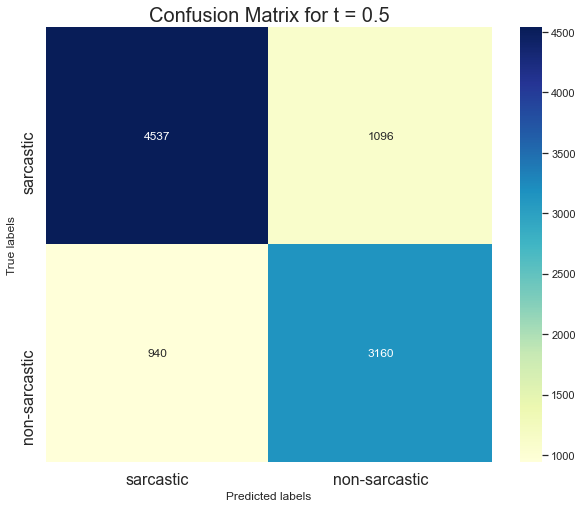

In [32]:
# Confusion matrix figure for the best-performing model - logistic regression (C=1) with the ...
#...standard threshold (t = 0.5)     

matrix_t5 = confusion_matrix(y_test, adjusted_classes(LR_y_pred, t=0.5),labels=[1, 0]) # include the labels parameter produce a confusion matrix from the perpective of the sarcatsic class

plt.figure(figsize=(10,8))
ax= plt.subplot()
sns.heatmap(matrix_t5, annot=True, ax = ax, fmt='g',cmap = 'YlGnBu'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix for t = 0.5', fontsize = 20) 
ax.xaxis.set_ticklabels(['sarcastic', 'non-sarcastic'], fontsize = 16) 
ax.yaxis.set_ticklabels(['sarcastic', 'non-sarcastic'], fontsize = 16)
plt.savefig('cm_t5.png')

# Reference (sns heatmap): https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
# Reference (sns heatmap): https://jakevdp.github.io/PythonDataScienceHandbook/05.05-naive-bayes.html

#### Threshold Analysis for the Logistic Regression Model of the Sarcasm Data - Exploring the Relationship Between Precision, Recall and Threshold Values

In [33]:
# Make binary or continuous predictions based on the best logistic regression model

# Make binary predictions based on the best logistic regression model
LR_y_pred_binary = LR.predict(X_test)

# Make a prediction on a continuous probability scale based on the best logistic regression model
LR_y_pred = LR.predict_proba(X_test)[:,1]


In [34]:
# Return evenly spaced array of values for testing classification metrics values at different thresholds

thresholds=np.arange(0,1,.01)

# Reference: https://docs.scipy.org/doc/numpy/reference/generated/numpy.arange.html


In [35]:
# Adjust the classification based on the prediction threshold

def adjusted_classes(LR_y_pred, t):
    
    return [1 if y >= t else 0 for y in LR_y_pred]

# Reference: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
# Reference: https://github.com/sdesaidata/Springboard/blob/master/Capstone1_Beer_Rating_Predictor/MachineLearning.ipynb


In [36]:
# Plot the precison recall curve and show the current value for each metric by identifying the classifier's threshold

def precision_recall_threshold(p, r, thresholds, t=0.5):
       
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(LR_y_pred, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    sns.set(style="whitegrid")
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)

# Reference: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65


In [37]:
# Generate precision-recall curves best on the test target data and the matching predicted probabilities ...
#... generated using the best model

p, r, thresholds = precision_recall_curve(y_test, LR_y_pred)


     pred_neg  pred_pos
neg      3160       940
pos      1096      4537


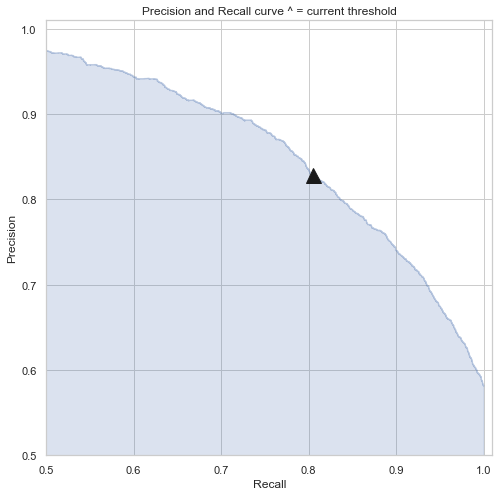

In [38]:
# Plot the precision-recall curve of the logistic regression model for the sarcasm data for the threshold = 0.5

precision_recall_threshold(p, r, thresholds, t=0.5)


     pred_neg  pred_pos
neg      2684      1416
pos       755      4878


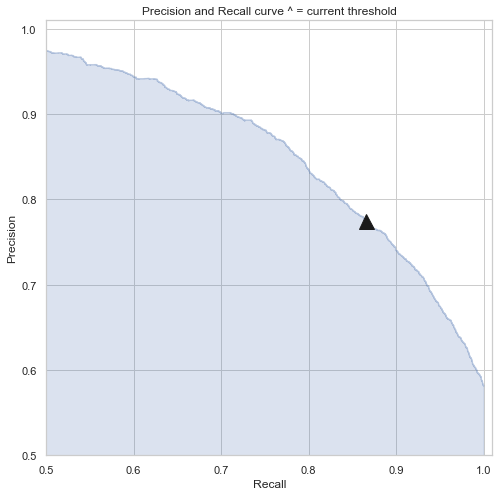

In [39]:
# Plot the precision-recall curve of the logistic regression model for the sarcasm data for the threshold = 0.4

precision_recall_threshold(p, r, thresholds, t=0.4)


     pred_neg  pred_pos
neg      2037      2063
pos       428      5205


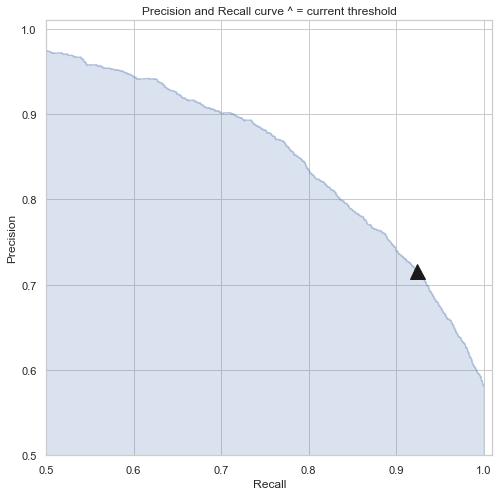

In [40]:
# Plot the precision-recall curve of the logistic regression model for the sarcasm data for the threshold = 0.3

precision_recall_threshold(p, r, thresholds, t=0.3)


     pred_neg  pred_pos
neg      1362      2738
pos       241      5392


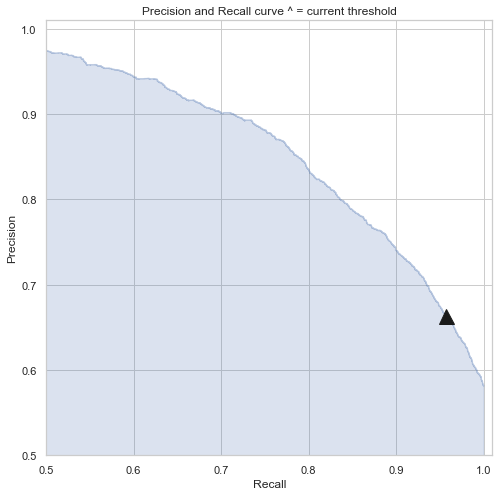

In [41]:
# Plot the precision-recall curve of the logistic regression model for the sarcasm data for the threshold = 0.2

precision_recall_threshold(p, r, thresholds, t=0.2)


     pred_neg  pred_pos
neg       618      3482
pos        85      5548


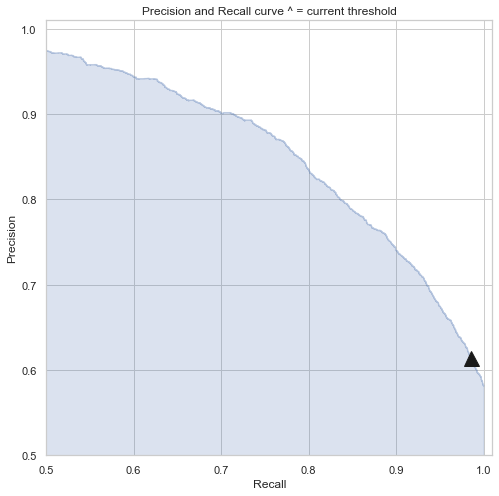

In [42]:
# Plot the precision-recall curve of the logistic regression model for the sarcasm data for the threshold = 0.1

precision_recall_threshold(p, r, thresholds, t=0.1)


     pred_neg  pred_pos
neg       290      3810
pos        31      5602


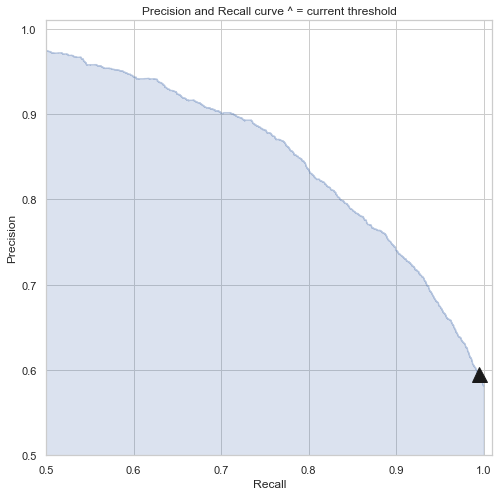

In [43]:
# Plot the precision-recall curve of the logistic regression model for the sarcasm data for the threshold = 0.05

precision_recall_threshold(p, r, thresholds, t=0.05)


     pred_neg  pred_pos
neg        44      4056
pos         1      5632


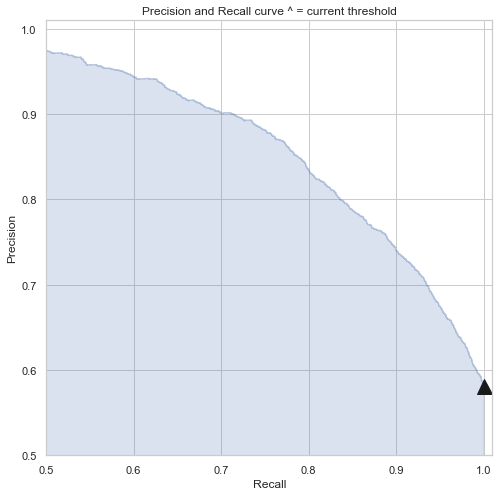

In [44]:
# Plot the precision-recall curve of the logistic regression model for the sarcasm data for the threshold = 0.01

precision_recall_threshold(p, r, thresholds, t=0.01)


Average precision score: 0.92


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.92')

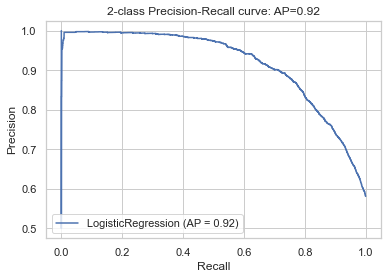

In [45]:
# Calculate the average precision score from predictions based on the best model and generate a precision-recall curve

LR_y_pred = LR.predict_proba(X_test)[:,1]
average_precision = average_precision_score(y_test, LR_y_pred)

print('Average precision score: {0:0.2f}'.format(
      average_precision))
disp = plot_precision_recall_curve(LR, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

# Reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py


### Business Applications

#### Business Scenario One: Maximize the Sarcasm Model's Ability to Detect Sarcastic Tweets

In [46]:
# Identify the threshold associated with the largest fbeta score
 
# Initialize an empty list to store fbeta scores
fbeta_points = []
# Define the starting largest score
largest_score = 0

# Loop through the array of threshold values to test
for t in thresholds:
    # Assign new binary class based on the new threshold
    adjusted_y_pred_scenario_one = adjusted_classes(LR_y_pred, t=t)
    # Calculate the new recall score based on the new assignments for the new threshold
    #  beta >1 which favors recall and beta <1 favors precision
    new_balance = fbeta_score(y_test, adjusted_y_pred_scenario_one, average='micro', beta = 10) # 'micro' calculates metrics globally by counting the total true...
    #...positives, false negatives and false positives
    # Append the new recall score to the list
    fbeta_points.append(new_balance)
    # Determine if the new recall score is the largest, and if so assign the score and threshold
    if new_balance > largest_score:
        largest_score = new_balance
        thresh = t
        #print(largest_score,thresh)
print("The largest fbeta score of",round((largest_score),4),"occurs at a threshold value of:",thresh)    
        
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html?highlight=fbeta


The largest fbeta score of 0.7999 occurs at a threshold value of: 0.5772851618800624


In [47]:
# Classification Report for the business scenario one - maximizing fbeta score and minimizing false negatives

print("Classification Report for the Business Application - Complementing Sentiment Analysis:\n",classification_report(adjusted_classes(LR_y_pred, 0.57728516188006244), y_test))
print("Confusion Matrix for the Business Application - Complementing Sentiment Analysis:\n",confusion_matrix(y_test, adjusted_classes(LR_y_pred, 0.5772851618800624)))

# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html


Classification Report for the Business Application - Complementing Sentiment Analysis:
               precision    recall  f1-score   support

           0       0.84      0.73      0.78      4720
           1       0.77      0.87      0.82      5013

    accuracy                           0.80      9733
   macro avg       0.81      0.80      0.80      9733
weighted avg       0.80      0.80      0.80      9733

Confusion Matrix for the Business Application - Complementing Sentiment Analysis:
 [[3436  664]
 [1284 4349]]


In [48]:
# Convert the classification report for the business application - complementing sentiment analysis into a DF

report = classification_report(adjusted_classes(LR_y_pred,t=0.58),y_test,output_dict=True)
df_cr = pd.DataFrame(report)
df_cr

# Reference: https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format


,0,1,accuracy,macro avg,weighted avg
precision,0.838780,0.771347,0.799753,0.805064,0.804097
recall,0.727523,0.867958,0.799753,0.797741,0.799753
f1-score,0.779200,0.816806,0.799753,0.798003,0.798542
support,4727.000000,5006.000000,0.799753,9733.000000,9733.000000


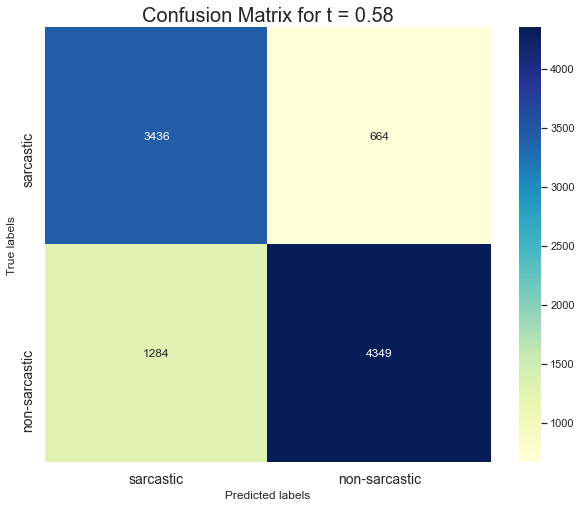

In [49]:
# Confusion matrix figure for the business application - complementing sentiment analysis     

matrix_scenario_one = confusion_matrix(y_test, adjusted_classes(LR_y_pred, t=0.5772851618800624))

plt.figure(figsize=(10,8))
ax= plt.subplot()
sns.heatmap(matrix_scenario_one, annot=True, ax = ax, fmt='g',cmap = 'YlGnBu'); # annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix for t = 0.58', fontsize=20) 
ax.xaxis.set_ticklabels(['sarcastic', 'non-sarcastic'], fontsize = 14) 
ax.yaxis.set_ticklabels(['sarcastic', 'non-sarcastic'], fontsize = 14)
plt.savefig('cm_t58.png')

# Reference (sns heatmap): https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
# Reference (sns heatmap): https://jakevdp.github.io/PythonDataScienceHandbook/05.05-naive-bayes.html

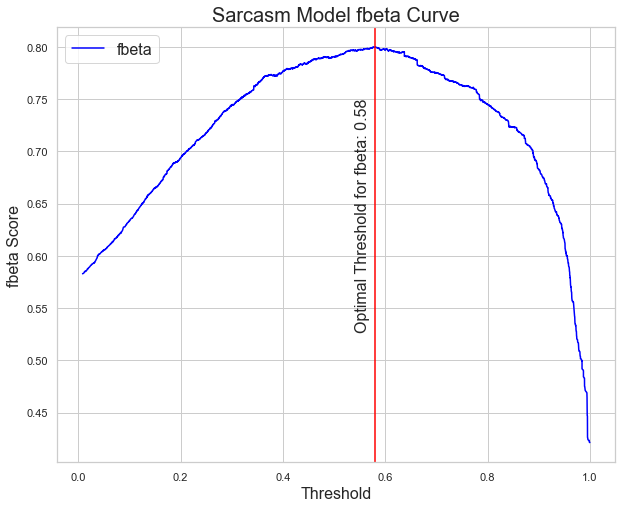

In [50]:
# Generate a figure showing variation in fbeta scores along with threshold values

sns.set(style="whitegrid")
plt.figure(figsize=(10,8))
plt.plot(thresholds, fbeta_points, color='blue', label = 'fbeta') #recall_points
#plt.plot(thresholds, balanced_accuracy_points, color='purple', label = "Balanced Accuracy")
plt.title('Sarcasm Model fbeta Curve', fontsize =20)
plt.legend('fbeta')
plt.xlabel('Threshold', fontsize = 16)
plt.axvline(x=.58, color='red') # check for value
plt.text(.54,.53,'Optimal Threshold for fbeta: 0.58 ',rotation=90, fontsize = 16)
#plt.axvline(x=.5, color='black') # check for value
#plt.text(.48,.73,'Optimal Threshold Balanced Acc.',rotation=90)
plt.ylabel('fbeta Score', fontsize = 16)
plt.legend(loc='upper left', fontsize  = 16)
plt.savefig('fbeta_curve.png')
plt.show()

# Reference: https://github.com/sdesaidata/Springboard/blob/master/Capstone1_Beer_Rating_Predictor/MachineLearning.ipynb        


#### Business Scenario Two: Maximize the Sarcasm Model's Ability to Capture an Accurate Product Sentiment

In [51]:
# Adjust class predictions based on the prediction threshold (t)

def adjusted_classes(LR_y_pred, t):
    
    return [1 if y >= t else 0 for y in LR_y_pred]

# Reference: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
# Reference: https://github.com/sdesaidata/Springboard/blob/master/Capstone1_Beer_Rating_Predictor/MachineLearning.ipynb


In [52]:
# Calculate accuracy score based on the default threshold = 0.5

accuracy_score(y_test, LR_y_pred_binary)

# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html


0.7908147539299291

In [53]:
# Calculate balanced accuracy score based on the default threshold = 0.5

balanced_accuracy_score(y_test, LR_y_pred_binary)

# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html


0.7880819907080662

In [54]:
# Return evenly spaced array of values for testing accuracy and balanced accuracy values at different thresholds

thresholds=np.arange(0,1,.01)

# Reference: https://docs.scipy.org/doc/numpy/reference/generated/numpy.arange.html


In [55]:
# Generate an array of sarcasm probability scores for each tweet

LR_y_pred = LR.predict_proba(X_test)[:,1]

# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba


In [56]:
# Identify the threshold associated with the largest accuracy score

# Initialize an empty list to store accuracy scores
accuracy_points = []
# Define the starting largest score
largest_score = 0

# Loop through the array of theshold values to test
for t in thresholds:
    # Assign new classes based on the new threshold
    adjusted_y_pred = adjusted_classes(LR_y_pred, t=t)
    # Calculate the new accuracy score based on the new assignments for the new threshold
    new_balance = accuracy_score(y_test, adjusted_y_pred)
    # Append the new accuracy score to the list
    accuracy_points.append(new_balance)
    # Determine if the new accuracy score is the largest, and if so assign the score and threshold
    if new_balance > largest_score:
        largest_score = new_balance
        thresh = t
        #print(largest_score,thresh)
print("The largest Accuracy Score of",round((largest_score),4),"occurs at a threshold value of:",thresh)    
        
# Reference: https://github.com/sdesaidata/Springboard/blob/master/Capstone1_Beer_Rating_Predictor/MachineLearning.ipynb        
        

The largest Accuracy Score of 0.7998 occurs at a threshold value of: 0.58


In [57]:
# Identify the threshold associated with the largest balanced accuracy score

# Initialize an empty list to store balanced accuracy scores
balanced_accuracy_points = []
# Define the starting largest score
largest_score = 0

# Loop through the array of theshold values to test
for t in thresholds:
    # Assign new classes based on the new threshold
    adjusted_y_pred = adjusted_classes(LR_y_pred, t=t)
    # Calculate the new accuracy score based on the new assignments for the new threshold
    new_balance = balanced_accuracy_score(y_test, adjusted_y_pred)
    # Append the new accuracy score to the list
    balanced_accuracy_points.append(new_balance)
    # Determine if the new accuracy score is the largest, and if so assign the score and threshold
    if new_balance > largest_score:
        largest_score = new_balance
        thresh = t
        #print(largest_score,thresh)
print("The largest Balanced Accuracy Score of",round((largest_score),4),"occurs at a threshold value of:",thresh)   

# Reference: https://github.com/sdesaidata/Springboard/blob/master/Capstone1_Beer_Rating_Predictor/MachineLearning.ipynb        
            

The largest Balanced Accuracy Score of 0.8055 occurs at a threshold value of: 0.61


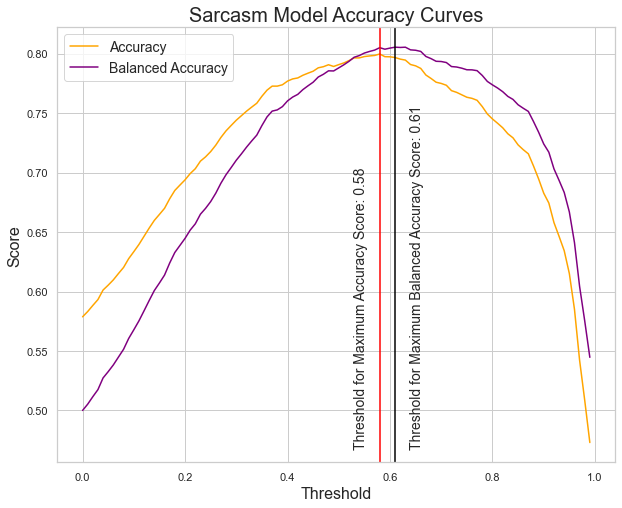

In [58]:
# Generate a figure showing variation in accuracy and balanced accuracy along with threshold values

sns.set(style="whitegrid")
plt.figure(figsize=(10,8))
plt.plot(thresholds, accuracy_points, color='orange', label = 'Accuracy')
plt.plot(thresholds, balanced_accuracy_points, color='purple', label = "Balanced Accuracy")
plt.title('Sarcasm Model Accuracy Curves', fontsize =20)
plt.legend(('Accuracy', 'Balanced Accuracy'))
plt.xlabel('Threshold', fontsize = 16)
plt.axvline(x=.58, color='red') # check for value
plt.text(.53,.47,'Threshold for Maximum Accuracy Score: 0.58',rotation=90, fontsize = 14)
plt.axvline(x=.61, color='black') # check for value
plt.text(.64,.47,'Threshold for Maximum Balanced Accuracy Score: 0.61',rotation=90, fontsize=14)
plt.ylabel('Score', fontsize = 16)
plt.legend(loc='best', fontsize  = 14)
plt.savefig('accuracy_curves.png')
plt.show()

# Reference: https://github.com/sdesaidata/Springboard/blob/master/Capstone1_Beer_Rating_Predictor/MachineLearning.ipynb        


#### Business Scenario Three: Balance the Risk of the Sarcasm Model's Mis-labeling of Non-sarcastic as Well as Sarcastic Tweets

In [59]:
# Generate an array of probability estimates for each tweet being sarcastic

LR_y_pred = LR.predict_proba(X_test)[:,1]

# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba


In [60]:
# Identify the threshold associated with the largest f1 score. The f1 score in this range of threshold values identifies the threshold where the...
#... model performs the best in this range

# Initialize an empty list to store balanced accuracy scores
f1_high_points = []
# Define the starting largest score
largest_score = 0

# Loop through the array of theshold values to test
for t in thresholds:
    # Assign new classes based on the new threshold
    adjusted_y_pred = adjusted_classes(LR_y_pred, t=t)
    # Calculate the new accuracy score based on the new assignments for the new threshold
    new_balance = f1_score(y_test, adjusted_y_pred)
    # Append the new accuracy score to the list
    f1_high_points.append(new_balance)
    # Determine if the new accuracy score is the largest, and if so assign the score and threshold
    if new_balance > largest_score:
        largest_score = new_balance
        thresh = t
        #print(largest_score,thresh)
print("The largest f1 score of",round((largest_score),4),"occurs at a threshold value of:",thresh)

# Reference: https://github.com/sdesaidata/Springboard/blob/master/Capstone1_Beer_Rating_Predictor/MachineLearning.ipynb        
            

The largest f1 score of 0.8192 occurs at a threshold value of: 0.46


In [61]:
# Classification Report for business scenario three

print("Classification Report for Business Scenario Three :\n",classification_report(y_test, adjusted_classes(LR_y_pred, t=0.46))) 
print("Confusion Matrix for Business Scenario Three:\n",confusion_matrix(y_test, adjusted_classes(LR_y_pred, t=0.46)))


Classification Report for Business Scenario Three :
               precision    recall  f1-score   support

           0       0.76      0.73      0.74      4100
           1       0.81      0.83      0.82      5633

    accuracy                           0.79      9733
   macro avg       0.78      0.78      0.78      9733
weighted avg       0.79      0.79      0.79      9733

Confusion Matrix for Business Scenario Three:
 [[2998 1102]
 [ 960 4673]]


In [62]:
# Classification report for business scenario three 

report = classification_report(y_test, adjusted_classes(LR_y_pred, t=0.39),output_dict=True)
df = pd.DataFrame(report)
df

# Reference: https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format


,0,1,accuracy,macro avg,weighted avg
precision,0.784367,0.768377,0.773862,0.776372,0.775112
recall,0.638780,0.872182,0.773862,0.755481,0.773862
f1-score,0.704127,0.816995,0.773862,0.760561,0.769450
support,4100.000000,5633.000000,0.773862,9733.000000,9733.000000


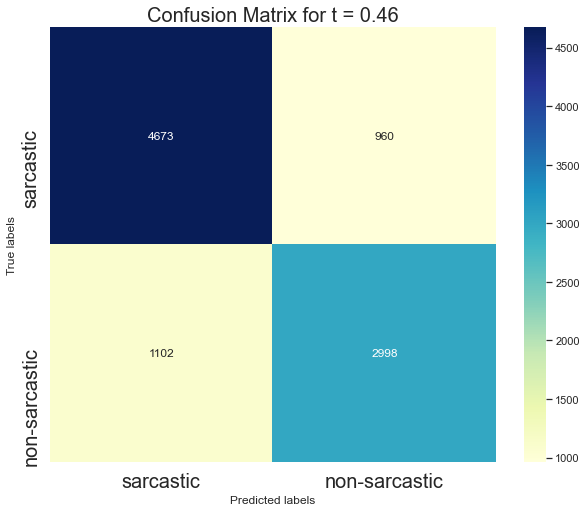

In [63]:
# Confusion matrix figure for business scenario three   

matrix_scenario_one = confusion_matrix(y_test, adjusted_classes(LR_y_pred, t=0.46), labels=[1, 0])

plt.figure(figsize=(10,8))
ax= plt.subplot()

sns.heatmap(matrix_scenario_one, annot=True, ax = ax, fmt='g',cmap = 'YlGnBu'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix for t = 0.46', fontsize=20) 
ax.xaxis.set_ticklabels(['sarcastic', 'non-sarcastic'], fontsize=20) 
ax.yaxis.set_ticklabels(['sarcastic', 'non-sarcastic'], fontsize=20)
plt.savefig('cm_t46.png')

# Reference (sns heatmap): https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
# Reference (sns heatmap): https://jakevdp.github.io/PythonDataScienceHandbook/05.05-naive-bayes.html

In [64]:
# Calculate the f1, recall and precision for the full range of threshold values: 0.0 - 1.0

# Initialize an empty list to store balanced accuracy scores
f1_scores = []
precision_scores = []
recall_scores = []

# Loop through the array of theshold values to test
for t in thresholds:
    
    # Assign new classes based on the new threshold
    adjusted_y_pred = adjusted_classes(LR_y_pred, t=t)
    
    # Calculate the new f1 score based on the new assignments for the new threshold
    new_f1_score = f1_score(y_test, adjusted_y_pred)
    # Append the new accuracy score to the list
    f1_scores.append(new_f1_score)
    
    # Calculate the new precision score based on the new assignments for the new threshold
    new_precision_score = precision_score(y_test, adjusted_y_pred)
    # Append the new accuracy score to the list
    precision_scores.append(new_precision_score)
    
    # Calculate the new recall score based on the new assignments for the new threshold
    new_recall_score = recall_score(y_test, adjusted_y_pred)
    # Append the new accuracy score to the list
    recall_scores.append(new_recall_score)



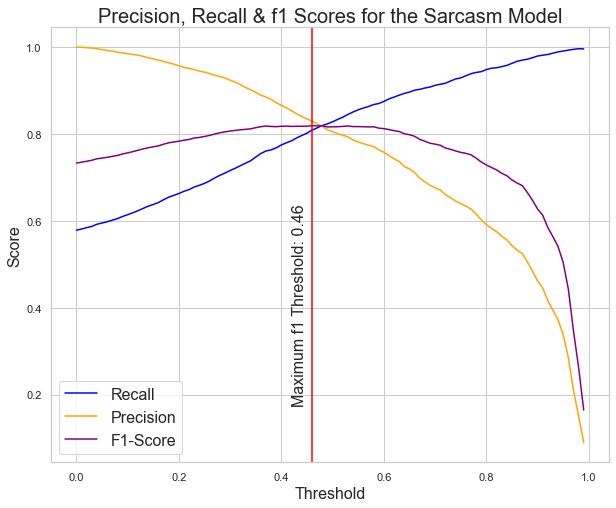

In [65]:
# Precision, Recall and F1 Score on a graph together for thresholds

plt.figure(figsize=(10,8))
plt.plot(thresholds, precision_scores, color='blue')
plt.plot(thresholds, recall_scores, color='orange')
plt.plot(thresholds, f1_scores, color='purple')
plt.title('Precision, Recall & f1 Scores for the Sarcasm Model', fontsize=20)
plt.legend(('Recall','Precision', 'F1-Score'), loc='best', fontsize = 16)
plt.xlabel('Threshold', fontsize =16)
plt.ylabel('Score', fontsize =16)
plt.axvline(x=.46, color='red')
plt.text(.42,.18,'Maximum f1 Threshold: 0.46',rotation=90, fontsize = 16)
#plt.axvline(x=.41, color='black')
#plt.text(.42,.18,'Satisifed Cusotmer Threshold',rotation=90, fontsize = 12)
#plt.axvline(x=.50, color='black')
#plt.text(.475,.18,'Default Threshold',rotation=90, fontsize = 12)
plt.savefig('max_f1_score.png')
plt.show()

# https://github.com/sdesaidata/Springboard/blob/master/Capstone1_Beer_Rating_Predictor/MachineLearning.ipynb


#### Business Scenario Four: Improving Sentiment Analysis Using Sarcasm Scores

In [66]:
# Read the original sarcasm training data (the format before preprocessing) into a DF for comparison with the Kaggle Twitter data prior to preprocessing...
#... the Kaggle Twitter data

sarc_data = pd.read_csv('all_sarc_and_matching_tweets.csv')


In [67]:
# Inspect the DF 'sarc_data'

sarc_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209877 entries, 0 to 209876
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Unnamed: 0      209877 non-null  int64 
 1   tweet_category  209877 non-null  int64 
 2   user            209877 non-null  object
 3   location        138670 non-null  object
 4   date            209877 non-null  object
 5   text            209877 non-null  object
dtypes: int64(2), object(4)
memory usage: 9.6+ MB


In [68]:
# Read in the Kaggle Twitter sentiment analysis data downloaded from https://www.kaggle.com/kazanova/sentiment140/data
# Assign column names matching the twitter sarcasm training data (above) which are the column names required by the preprocessor 'Preprocessor.py'
# The Kaggle data also contains two additional columns - 'tweet_id' and 'query' not required by the preprocessor. These can be left alone
# In order to use the preprocessor, the Kaggle Twitter DF should mimic the structure of the sarcasm data  

kag_data = pd.read_csv('kaggle_twitter_sent_data.csv', names =['tweet_category','tweet_id','date','query','user','text'],encoding='latin-1' )


In [69]:
# Check the columns of the Kaggle Twitter DF 'kag_data' to check conformity with the sarcasm DF 'sarc_data'
# In order to use the preprocessor, the Kaggle Twitter DF should mimic the structure of the sarcasm data  

kag_data.head(2)


,tweet_category,tweet_id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Thi..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School to...


In [70]:
# Check the basic structure of the Kaggle Twitter data DF to check conformity with the sarcasm DF 'sarc_data'
# In order to use the preprocessor, the Kaggle Twitter DF should mimic the structure of the sarcasm data  

kag_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   tweet_category  1600000 non-null  int64 
 1   tweet_id        1600000 non-null  int64 
 2   date            1600000 non-null  object
 3   query           1600000 non-null  object
 4   user            1600000 non-null  object
 5   text            1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [71]:
# Check the existing level and number of rows for each level in the 'tweet_category' column of the Kaggle Twitter DF. The native 'positive' category ....
#...is labeled '4' and the native 'negative' category is labeled '0'

kag_data.tweet_category.value_counts()


4    800000
0    800000
Name: tweet_category, dtype: int64

In [72]:
# Change the native 'negative' category (0) of the Kaggle Twitter data to one in order to match the structure of the sarcastic tweets DF 'sarc_data'...
#...where sarcastic tweets carry the label one

kag_data.loc[(kag_data.tweet_category == 0), 'tweet_category'] = 1
kag_data.tweet_category.value_counts()


4    800000
1    800000
Name: tweet_category, dtype: int64

In [73]:
# Change the native 'positive' category (4) of the Kaggle Twitter data to zero in order to match the structure of the sarcastic tweets DF 'sarc_data' ...
#...where non-sarcastic tweets carry the label zero

kag_data.loc[(kag_data.tweet_category == 4), 'tweet_category'] = 0
kag_data.tweet_category.value_counts()


1    800000
0    800000
Name: tweet_category, dtype: int64

In [74]:
# Confirm the changes to the 'tweet_category' column of the Kaggle Twitter data

kag_data.head(2)


,tweet_category,tweet_id,date,query,user,text
0,1,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Thi..."
1,1,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School to...


In [75]:
# Reduce the size of the Kaggle Twitter data to match the size of the sarcasm data prior to preprocessing. This reduces preprocessing time significantly....
#... and eliminates potential bias related to unequal sample sizes between the larger kaggle data and the smaller sarcasm data

kag_data_small = kag_data.sample(n= len(sarc_data), random_state = 1)


In [76]:
# Check the structure of the new, smaller DF containing a sub-sample of the original Kaggle Twitter data

kag_data_small.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 209877 entries, 514293 to 1451141
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   tweet_category  209877 non-null  int64 
 1   tweet_id        209877 non-null  int64 
 2   date            209877 non-null  object
 3   query           209877 non-null  object
 4   user            209877 non-null  object
 5   text            209877 non-null  object
dtypes: int64(2), object(4)
memory usage: 11.2+ MB


In [77]:
# Verify the new smaller Kaggle Twitter DF contains roughly equal counts for each level of the 'tweet_category' column

kag_data_small.tweet_category.value_counts()


0    105079
1    104798
Name: tweet_category, dtype: int64

In [78]:
# Insert a dummy 'location' column in the reduced-size Kaggle Twitter DF since the tweet preprocessor expects this and set the value = 'United States'...
#... for all rows so none of the rows are accidentally filtered out by the preprocessor 'Preprocessor.py'

kag_data_small.insert(loc=0,column='location',value='United States')


In [79]:
# Check the changes to the Kaggle Twitter DF

kag_data_small.head(2)


,location,tweet_category,tweet_id,date,query,user,text
514293,United States,1,2190584004,Tue Jun 16 03:08:48 PDT 2009,NO_QUERY,Vicki_Gee,i miss nikki nu nu already shes always there when needed thank u xxx
142282,United States,1,1881451988,Fri May 22 04:42:15 PDT 2009,NO_QUERY,PatCashin,So I had a dream last night. I remember a sign which clearly told me where to get a job. I can...


In [80]:
# Convert the Kaggle Twitter DF into a .csv to save externally and as a parameter for the preprocessor - 'Preprocessor.py'

kag_data_small.to_csv('kag_data_small.csv')


In [81]:
# Alternative approach to unpickling the preprocessed reduced-size Kaggle Twitter data
# Perform the same preprocessing steps on the reduced-sized kaggle twitter data as previously accomplished for the sarcasm data
# Calling this from Jupyter notebook potentially takes longer than using the preprocessor directly in Ipython
# This approach is preferable since it avoids potentially confusing data sets
# Currently not working 

# Instantiate a preprocessor instance with the reduced-size kaggle twitter data
#prepro_inst_kag = Preprocessor('kag_data_small.csv')

# Call the 'tweet_format' method on the preprocessor instance
#prepro_inst_kag.tweet_format()


In [82]:
# load the preprocessor instance including attributes, most importantly the preprocessed DF containing the ...
#... preprocessed reduced-sized Kaggle Twitter data from 'kag_data_small.csv'

preprop_inst = OOP_pickle_util.load_preprocessor_instance('sent_prepro_inst_pickled') 
            

In [83]:
# Rename the DF attribute from the preprocessor instance after processing the Kaggle Twitter data

kag_df = preprop_inst.df

# Check the DF
kag_df.head(2)


,political_score,text33,tweet_cat,original_tweet,text34,text35,text36,text_final
0,0.029545,already she s always needed thank,1,i miss nikki nu nu already shes always there when needed thank u xxx,"[already, she, s, always, needed, thank]","[already, she, always, needed, thank]",5,already she always needed thank
1,0.425422,dream last night remember sign clearly told get job can not rememer sign said,1,So I had a dream last night. I remember a sign which clearly told me where to get a job. I can...,"[dream, last, night, remember, sign, clearly, told, get, job, can, not, rememer, sign, said]","[dream, last, night, remember, sign, clearly, told, get, job, can, not, rememer, sign, said]",14,dream last night remember sign clearly told get job can not rememer sign said


In [84]:
# Investigate the DF resulting from preprocessing of the Kaggle Twitter data - 'kag_df' structure

kag_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 148372 entries, 0 to 209876
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   political_score  148372 non-null  float64
 1   text33           148372 non-null  object 
 2   tweet_cat        148372 non-null  int64  
 3   original_tweet   148372 non-null  object 
 4   text34           148372 non-null  object 
 5   text35           148372 non-null  object 
 6   text36           148372 non-null  int64  
 7   text_final       148372 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 10.2+ MB


In [85]:
# Create the feature and target arrays for developing a sentiment model using the Kaggle Twitter data

# Create the feature array
X_kag = kag_df.text_final

# Create the target array 
y_kag = kag_df['tweet_cat'].values.astype(np.int) 


In [86]:
# Split the Kaggle Twitter data target and feature arrays into training and testing splits

X_traink, X_testk, y_traink, y_testk = train_test_split(X_kag, y_kag, test_size=0.2, random_state=42)


In [87]:
# Vectorize the training and test feature array splits of the Kaggle Twitter data

# Instantiate CountVectorizer
vectorizer = CountVectorizer()

# learn the vocabulary and create a document-term matrix/sparse array (DTM) for the training split features of the Kaggle Twitter data
X_traink = vectorizer.fit_transform(X_traink)

# Create a document-term matrix/sparse array (DTM) based on the training data for the test split features of the Kaggle Twitter data
X_testk = vectorizer.transform(X_testk)
           

In [88]:
# Define the classsifier and hyperparameters for the sentiment analysis of the Kaggle Twitter data

# Instantiate the classifier
MNB = MultinomialNB()

# Set the hyperparameters to test during model tuning
MNB_params = {'alpha':[0.01, 0.05, 0.1, 0.15, 0.25, 0.5, 1, 1.5, 2.5, 5, 7.5, 10, 15, 50]}


In [89]:
# Conduct the sentiment analysis of the Kaggle Twitter data including model tuning and produce classification metrics

# Build a naive Bayes sentiment model and tune it
gridk = GridSearchCV(MNB, MNB_params, n_jobs = -1, scoring = 'f1')
    
# Fit the gridsearch model to the training splits
grid_searchk = gridk.fit(X_traink, y_traink)

# Make predictions for X_testk based on the best parameters.The refitted GridSearchCV estimator...
#....is made available as the best_estimator_ attribute and permits using predict ...
#...directly on this GridSearchCV instance. Predict produces binary classifications predictions 
y_predk = grid_searchk.predict(X_testk)

# Continuous probability estimates for the sentiment analysis
y_predk_p = grid_searchk.predict_proba(X_testk)[:,1]
    
# Create a confusion matrix comparing the test target values with the predicted values
cmk = metrics.confusion_matrix(y_testk, y_predk)
    
# Print the best score based on the scoring method, in this case 'f1'
# Mean cross-validated score of the best_estimator
print("Best f1 score:", grid_searchk.best_score_) 
    
# Print a classification report for the best model
print(classification_report(y_testk, y_predk))
print('\nConfusion Matrix:\n', cmk)

# Print the best parameters identified by gridsearching
print("Best hyperparameters:", grid_searchk.best_params_)

Best f1 score: 0.7517554718632483
              precision    recall  f1-score   support

           0       0.78      0.63      0.69     14756
           1       0.69      0.82      0.75     14919

    accuracy                           0.72     29675
   macro avg       0.73      0.72      0.72     29675
weighted avg       0.73      0.72      0.72     29675


Confusion Matrix:
 [[ 9246  5510]
 [ 2660 12259]]
Best hyperparameters: {'alpha': 15}


In [90]:
# Return evenly spaced array of values for testing classification metrics at different thresholds

thresholds=np.arange(0,1,.01)

# Reference: https://docs.scipy.org/doc/numpy/reference/generated/numpy.arange.html


In [1788]:
# Make binary or continuous predictions based on the best logistic regression model of the sarcasm data

# Make binary predictions based on the best logistic regression model
LR_y_pred_binary = LR.predict(X_test)

# Make a prediction on a continuous probability scale based on the best logistic regression model
LR_y_pred = LR.predict_proba(X_test)[:,1]


The largest f1 score of 0.7518 occurs at a threshold value of: 0.48


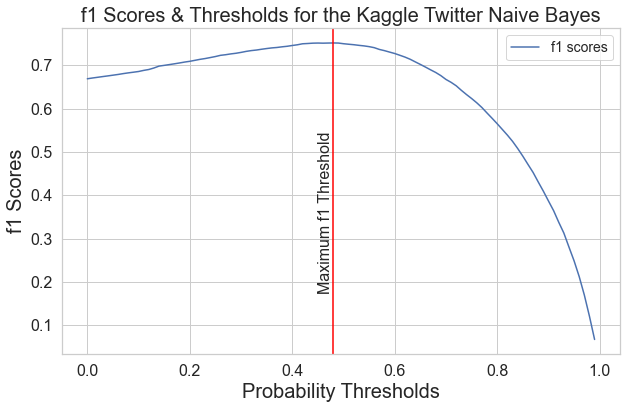

In [92]:
# Identify the threshold associated with the largest f1 score for the sentiment analysis of the Kaggle Twitter data using naive Bayes
# The f1 score links to the threshold where the model performs the best in this range
# Produce a lineplot comparing f1 scores with threshold values

# Initialize an empty list to store f1 scores
f1_mnb_scores = []
# Define the starting largest score
f1_mnb_largest = 0

# Loop through the array of theshold values to test
for t in thresholds:
    # Assign new classes to the predicted value from the best MNB model based on the new threshold using def 'adjusted_classes'
    adjusted_y_pred = adjusted_classes(y_predk_p, t=t)
    # Calculate the new accuracy score based on the new assignments for the new threshold. Compare the true values from 'y_testk' with the adjusted values...
    #... 'adjusted_y_pred' resulting from the current threshold
    new_f1 = f1_score(y_testk, adjusted_y_pred)
    # Append the new accuracy score to the list
    f1_mnb_scores.append(new_f1)
    # Determine if the new accuracy score is the largest, and if so assign the score and threshold
    if new_f1 > f1_mnb_largest:
        f1_mnb_largest = new_f1
        thresh = t
        #print(largest_score,thresh)
print("The largest f1 score of",round((f1_mnb_largest),4),"occurs at a threshold value of:",thresh)

f1_z = zip(thresholds,f1_mnb_scores) # zip the thresholds list and scores list
new_t_f1 = list(f1_z) # convert the zip object into a list
#new_t_f1 # show the thresholds and their f1 scores for the MNB analysis of the Kaggle Twitter data

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
ax = sns.lineplot(x=thresholds, y=f1_mnb_scores, label = 'f1 scores')
ax.axes.set_title("f1 Scores & Thresholds for the Kaggle Twitter Naive Bayes",fontsize=20)
ax.set_xlabel("Probability Thresholds",fontsize=20)
ax.set_ylabel("f1 Scores",fontsize=20)
ax.tick_params(labelsize=16)
plt.axvline(x=.48, color='red') # vertical line at maximum f1 score
plt.text(.45,.18,'Maximum f1 Threshold',rotation=90, fontsize = 16)
#ax.axvline(0.48, color = 'red', label = "f1 Maximum Threshold") # vertical line at score without thresholding
plt.legend(loc ='best',fontsize = 14 )
plt.savefig('kag_f1_lineplot.png')

# Reference: https://github.com/sdesaidata/Springboard/blob/master/Capstone1_Beer_Rating_Predictor/MachineLearning.ipynb        
            

In [93]:
# Obtain binary classification values associated with the maximum f1 score (t = 0.48) of the Kaggle Twitter data sentiment analysis using naive Bayes 

max_f1_y = adjusted_classes(y_predk_p, t=.48) # use the probabilities from the naive Bayes to adjust the classes linked to...
                                              #...the threshold that maximizes f1


In [94]:
# Assign the preprocessor df containing the full sarcasm training data

df = pre_inst_s.df

# Check the working df
df.head(2)


,political_score,text33,tweet_cat,original_tweet,text34,text35,text36,text_final
0,0.488090,deep state dems continue attack machine anything stop,1,b'RT @TribulationThe: Deep State Dems continue to ATTACK EACH OTHER! BUST OUT POPCORN!!! \xf0\...,"[deep, state, dems, continue, attack, machine, anything, stop]","[deep, state, dems, continue, attack, machine, anything, stop]",8,deep state dems continue attack machine anything stop
7,0.359033,would see would ban stay h,1,"b'RT @TribulationThe: Only in Leftist, Kommie Kalifornia, would you see such HATRED such as this...","[would, see, would, ban, stay, h]","[would, see, would, ban, stay]",5,would see would ban stay


In [95]:
# Create the feature and target arrays for modeling the sarcasm training data using classifier algorithms

# Create the feature array
X = df.text_final

# Create the target array 
y = df['tweet_cat'].values.astype(np.int) 


In [96]:
# Create the feature and target arrays for developing a sentiment model using the Kaggle Twitter data

# Create the feature array
X_kag = kag_df.text_final

# Create the target array 
y_kag = kag_df['tweet_cat'].values.astype(np.int) 


In [97]:
# Split the sarcasm data's target and feature arrays into training and testing splits

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [98]:
# Split the Kaggle Twitter data target and feature arrays into training and testing splits for subsequent cross validation

X_traink, X_testk, y_traink, y_testk = train_test_split(X_kag, y_kag, test_size=0.2, random_state=42)


In [99]:
# Vectorize the training and test feature array splits

# Instantiate CountVectorizer
vectorizer = CountVectorizer()

# learn the vocabulary and create a document-term matrix (DTM)/sparse array for the training split features of the sarcasm data
# Reassign the training features
X_train = vectorizer.fit_transform(X_train)

X_test = vectorizer.transform(X_test)

# Create a document-term matrix based on the training data DTM/sparse array for the test split features of the sarcasm data but applied to the...
#...testing features of the Kaggle Twitter data
X_testk = vectorizer.transform(X_testk)
           

In [100]:
# Instantiate a logistic regression model and fit the sarcasm training data

LR = LogisticRegression(C = 1)
LR.fit(X_train, y_train)


LogisticRegression(C=1)

In [101]:
# Use the sarcasm model to obtain sarcasm probability scores for the Kaggle Twitter test features sparse array / DTM

y_predk_sarc = LR.predict_proba(X_testk)[:,1] 
y_predk_sarc


array([0.22081861, 0.28605264, 0.49493542, ..., 0.31091408, 0.02957137,
       0.60587269])

In [102]:
# Create a DF with columns consisting of labels based on the best f1 score for the naive Bayes model'max_f1_y' and sarcasm scores using...
#... the sarcasm model for the test features in the Kaggle Twitter data - 'y_predk_sarc'
# 'max_f1_y' is the array of binary classifications of the test feature array for the threshold that maximizes the f1 score from the ....
#...naive Byaes for the Kaggle Twitter data
# 'y_predk_sarc' holds the the sarcasm probability scores for the test features array of the Kaggle Twitter data

kag_f1_sarc = pd.DataFrame() # create an empty DF 
kag_f1_sarc['max_f1_y'] = max_f1_y
kag_f1_sarc['y_predk_sarc'] = y_predk_sarc
kag_f1_sarc.head(2)

,max_f1_y,y_predk_sarc
0,1,0.220819
1,1,0.286053


In [166]:
# Flip positive labels to negative if the sarcasm score is above a threshold value

def flip_pos(df):
     
    if df['max_f1_y'] == 0  and df['y_predk_sarc'] > t: # flip a negative label to a positive label if the sarcasm score is under a threshold value
        return 1
    elif df['max_f1_y'] == 0 and df['y_predk_sarc'] < t: # keep the rows with sarcasm scores above the threshold negatively-labeled
        return 0
    else:
        return 1 # make sure the rows with positive labels remain unchanged

In [181]:
# Evaluate the sarcasm scores of the Kaggle Twitter data and flip the positive labels to negative if the sarcasm score exceeds the threshold (t)
# Call the 'flip_pos' function on each row of the DF 'kag_f1_sarc' 

pos_flip_scores = [] # Create an empty list for collecting the f1 scores associated with each threshold 

for num in thresholds:
    t = num
    kag_f1_sarc['y_pred_w_sarcasm'] = kag_f1_sarc['max_f1_y'] # Reset the value of the 'y_pred_w_sarcasm' column to match the 'tweet_cat' column...
        #...prior to analysis
    kag_f1_sarc['y_pred_w_sarcasm'] = kag_f1_sarc.apply(flip_pos, axis=1) # Call the function which executes label flipping
    y_pred_w_sarcasm = kag_f1_sarc['y_pred_w_sarcasm'] # create an array from the new column containing the new labels based on sarcasm scores
    score = f1_score(y_testk, y_pred_w_sarcasm) # calculate the f1 score by comparing the test target data and the new labels for the Kaggle Twitter data 
    pos_flip_scores.append(score)
    
thresh_scores_pos = list(zip(thresholds,pos_flip_scores)) # Create a list of threshold, f1 score pairs
max(thresh_scores_pos, key=lambda x:x[1]) # yield the maximum f1 score and associated threshold

(0.99, 0.751828085360394)

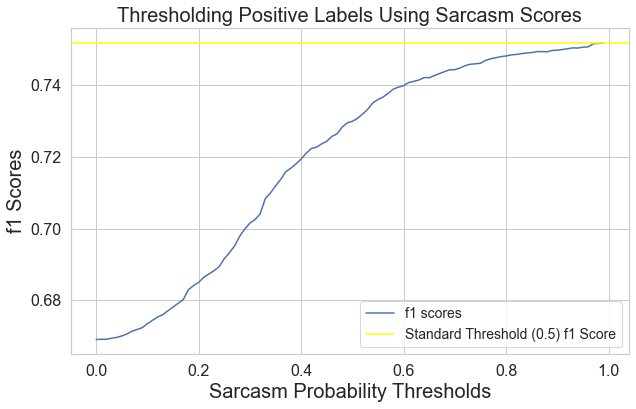

In [183]:
# Plot relationship between thresholds and f1 scores from flipping positive labels based on those thresholds

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
ax = sns.lineplot(x=thresholds, y=pos_flip_scores, label = 'f1 scores')
ax.axes.set_title("Thresholding Positive Labels Using Sarcasm Scores",fontsize=20)
ax.set_xlabel("Sarcasm Probability Thresholds",fontsize=20)
ax.set_ylabel("f1 Scores",fontsize=20)
ax.tick_params(labelsize=16)
#plt.text(.55,.745,'Standard Threshold (0.5) f1 Score',fontsize = 16)
plt.axhline(y=.7518, color='yellow',label = "Standard Threshold (0.5) f1 Score") # vertical line at maximum f1 score
#plt.text(.43,.68,'Maximum f1 Threshold: 0.46',rotation=90, fontsize = 16)
#ax.axvline(0.48, color = 'red', label = "f1 Maximum Score Threshold (0.46)") # vertical line at score without thresholding
plt.legend(loc ='best',fontsize = 14 )
plt.savefig('pos_flip_lineplot.png')

In [159]:
# Flip negative labels to positive if the sarcasm score is below a threshold value

def flip_neg(df):
     
    if df['max_f1_y'] == 1  and df['y_predk_sarc'] < t: # flip a negative label to a positive label if the sarcasm score is under a threshold value
        return 0
    elif df['max_f1_y'] == 1 and df['y_predk_sarc'] > t: # keep the rows with sarcasm scores above the threshold negatively-labeled
        return 1
    else:
        return 0 # make sure the rows with positive labels remain unchanged

In [184]:
# call the 'flip_neg' function on each row of the DF 'kag_f1_sarc' 

neg_flip_scores = [] # Create an empty list for collecting the f1 scores associated with each threshold 

for num in thresholds:
    t = num
    kag_f1_sarc['y_pred_w_sarcasm'] = kag_f1_sarc['max_f1_y'] # Reset the value of the 'y_pred_w_sarcasm' column to match the 'max_f1_y column prior to each analysis
    kag_f1_sarc['y_pred_w_sarcasm'] = kag_f1_sarc.apply(flip_neg, axis=1) # Call the function which executes label flipping
    y_pred_w_sarcasm = kag_f1_sarc['y_pred_w_sarcasm']
    score = f1_score(y_testk, y_pred_w_sarcasm)
    neg_flip_scores.append(score)
    
thresh_scores_neg = list(zip(thresholds,neg_flip_scores)) # Create a list of threshold, f1 score pairs
max(thresh_scores_neg, key=lambda x:x[1])

(0.0, 0.7517984537774992)

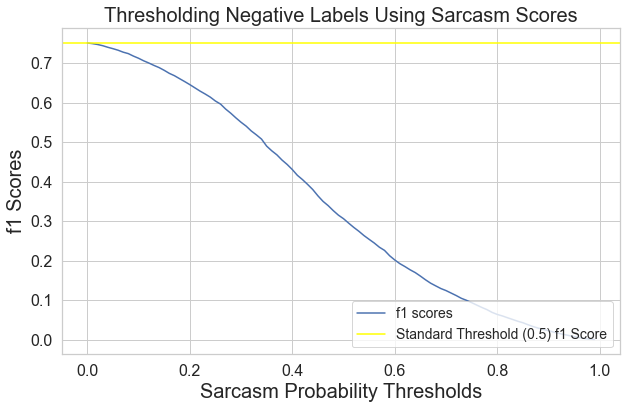

In [185]:
# Plot relationship between thresholds and f1 scores from flipping negative labels based on those thresholds

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
ax = sns.lineplot(x=thresholds, y=neg_flip_scores, label = 'f1 scores')
ax.axes.set_title("Thresholding Negative Labels Using Sarcasm Scores",fontsize=20)
ax.set_xlabel("Sarcasm Probability Thresholds",fontsize=20)
ax.set_ylabel("f1 Scores",fontsize=20)
ax.tick_params(labelsize=16)
#plt.text(.01,.7,'Standard Threshold (0.5) f1 Score',fontsize = 16)
plt.axhline(y=.7518, color='yellow',label = "Standard Threshold (0.5) f1 Score") # vertical line at maximum f1 score
#plt.text(.29,.25,'Maximum f1 Threshold: 0.34',rotation=90, fontsize = 16)
#ax.axvline(0.34, color = 'red', label = "f1 Maximum Score Threshold (0.34)") # vertical line at score without thresholding
plt.legend(loc ='lower right',fontsize = 14 )
plt.savefig('neg_flip_lineplot.png')

In [186]:
# Flip negative labels to positive and positive labels to negative labels based on the same threshold sarcasm score

def flip_both(df):    
    if df['max_f1_y'] == 1  and df['y_predk_sarc'] < t: # flip a negative label to a positive label if the sarcasm score is under a threshold value
        return 0  
    elif df['max_f1_y'] == 1 and df['y_predk_sarc'] > t: # keep the rows with sarcasm scores above the threshold negatively-labeled
        return 1
    elif df['max_f1_y'] == 0  and df['y_predk_sarc'] > t: # if the label is positive (zero), flip to negative (one) if the score > threshold
        return 1
    elif df['max_f1_y'] == 0 and df['y_predk_sarc'] < t: # if the label is positive and the score is < threshold, keep the label positive (zero)
        return 0


In [188]:
# call the 'flip_both' function on each row of the DF 'kag_f1_sarc' 

both_flip_scores = [] # Create an empty list for collecting the f1 scores associated with each threshold 

for num in thresholds:
    t = num
    kag_f1_sarc['y_pred_w_sarcasm'] = kag_f1_sarc['max_f1_y'] # Reset the value of the 'y_pred_w_sarcasm' column to match the 'max_f1_y' column prior to each analysis
    kag_f1_sarc['y_pred_w_sarcasm'] = kag_f1_sarc.apply(flip_both, axis=1) # Call the function which executes label flipping
    y_pred_w_sarcasm = kag_f1_sarc['y_pred_w_sarcasm']
    score = f1_score(y_testk, y_pred_w_sarcasm)
    both_flip_scores.append(score)

thresh_scores_both = list(zip(test,both_flip_scores)) # Create a list of threshold, f1 score pairs
#thresh_scores_both = list(zip(thresholds,both_flip_scores)) # Create a list of threshold, f1 score pairs
max(thresh_scores_both, key=lambda x:x[1])

(0.6, 0.6691034668341032)

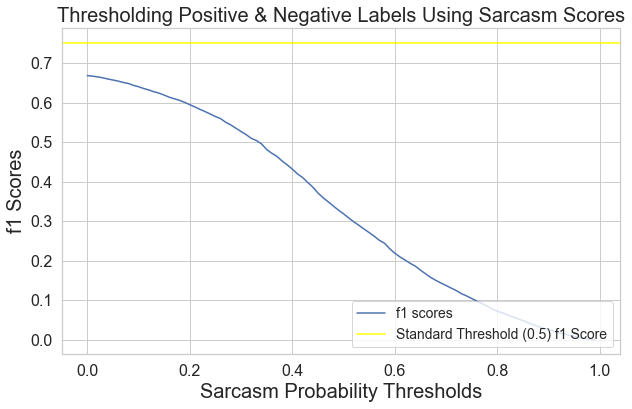

In [189]:
# Plot relationship between thresholds and f1 scores from flipping both positive and negative labels based on those thresholds

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
ax = sns.lineplot(x=thresholds, y=both_flip_scores, label = 'f1 scores')
ax.axes.set_title("Thresholding Positive & Negative Labels Using Sarcasm Scores",fontsize=20)
ax.set_xlabel("Sarcasm Probability Thresholds",fontsize=20)
ax.set_ylabel("f1 Scores",fontsize=20)
ax.tick_params(labelsize=16)
#plt.text(.01,.7,'Standard Threshold (0.5) f1 Score',fontsize = 16)
plt.axhline(y=.7518, color='yellow',label = "Standard Threshold (0.5) f1 Score") # vertical line at maximum f1 score
#plt.text(.29,.25,'Maximum f1 Threshold: 0.34',rotation=90, fontsize = 16)
#ax.axvline(0.39, color = 'red', label = "f1 Maximum Score Threshold (0.39)") # vertical line at score without thresholding
plt.legend(loc ='lower right',fontsize = 14 )
plt.savefig('both_flip_lineplot.png')

In [190]:
# Combine all three curves in same plot by concatenating results from flipping positive labels, flipping negative labels and flipping both...
#.... into the same DF

# Create a DF using the f1 scores from flipping positives 
pos_flip_scores = pd.DataFrame(pos_flip_scores)
pos_flip_scores['thresholds'] = thresholds

# Create a DF using the ROC_AUC scores from flipping negatives
neg_flip_scores = pd.DataFrame(neg_flip_scores)
neg_flip_scores['thresholds'] = thresholds

# Create a DF using the ROC_AUC scores from flipping both negative and positive labels
both_flip_scores = pd.DataFrame(both_flip_scores)
both_flip_scores['thresholds'] = thresholds

# Combine the three DFs
all_flip_scores = pd.concat([pos_flip_scores.assign(dataset='pos_flip_scores'), neg_flip_scores.assign(dataset='neg_flip_scores'),
                        both_flip_scores.assign(dataset='both_flip_scores')])

In [191]:
# Check the DF

all_flip_scores.head(2)

,0,thresholds,dataset
0,0.669103,0.00,pos_flip_scores
1,0.669150,0.01,pos_flip_scores


In [192]:
# Rename the score column

all_flip_scores = all_flip_scores.rename(columns = {0:'f1_score'})


In [193]:
# Check the DF

all_flip_scores.head(2)


,f1_score,thresholds,dataset
0,0.669103,0.00,pos_flip_scores
1,0.669150,0.01,pos_flip_scores


In [194]:
# Sort the DF by scores

all_flip_scores.sort_values(by='f1_score',ascending=False)

# Check the DF
all_flip_scores.head()


,f1_score,thresholds,dataset
0,0.669103,0.00,pos_flip_scores
1,0.669150,0.01,pos_flip_scores
2,0.669167,0.02,pos_flip_scores
3,0.669455,0.03,pos_flip_scores
4,0.669685,0.04,pos_flip_scores


In [195]:
# Reset the index

all_flip_scores = all_flip_scores.reset_index()

# Check the DF
all_flip_scores.head()


,index,f1_score,thresholds,dataset
0,0,0.669103,0.00,pos_flip_scores
1,1,0.669150,0.01,pos_flip_scores
2,2,0.669167,0.02,pos_flip_scores
3,3,0.669455,0.03,pos_flip_scores
4,4,0.669685,0.04,pos_flip_scores


In [196]:
# Remove the 'index' column

del all_flip_scores['index']

# Check the DF
all_flip_scores.head()


,f1_score,thresholds,dataset
0,0.669103,0.00,pos_flip_scores
1,0.669150,0.01,pos_flip_scores
2,0.669167,0.02,pos_flip_scores
3,0.669455,0.03,pos_flip_scores
4,0.669685,0.04,pos_flip_scores


In [197]:
# Sort the DF by scores

all_flip_scores = all_flip_scores.sort_values(by='f1_score',ascending=False)

# Check the DF
all_flip_scores.head(10)


,f1_score,thresholds,dataset
99,0.751828,0.99,pos_flip_scores
100,0.751798,0.00,neg_flip_scores
98,0.751693,0.98,pos_flip_scores
97,0.751611,0.97,pos_flip_scores
96,0.750730,0.96,pos_flip_scores
95,0.750648,0.95,pos_flip_scores
93,0.750461,0.93,pos_flip_scores
94,0.750409,0.94,pos_flip_scores
92,0.750223,0.92,pos_flip_scores
101,0.750187,0.01,neg_flip_scores


In [198]:
# Rename the 'dataset' column of DF 'all_flip_scores'

all_flip_scores = all_flip_scores.rename(columns ={'dataset':'Threshold Type'})


In [199]:
# Rename values in the 'Threshold Type' column

all_flip_scores["Threshold Type"].replace({'both_flip_scores':'Positive & Negative','pos_flip_scores':'Positive','neg_flip_scores':'Negative'}, inplace=True)


In [200]:
all_flip_scores.head(30)

,f1_score,thresholds,Threshold Type
99,0.751828,0.99,Positive
100,0.751798,0.00,Negative
98,0.751693,0.98,Positive
97,0.751611,0.97,Positive
96,0.750730,0.96,Positive
95,0.750648,0.95,Positive
93,0.750461,0.93,Positive
94,0.750409,0.94,Positive
92,0.750223,0.92,Positive
101,0.750187,0.01,Negative


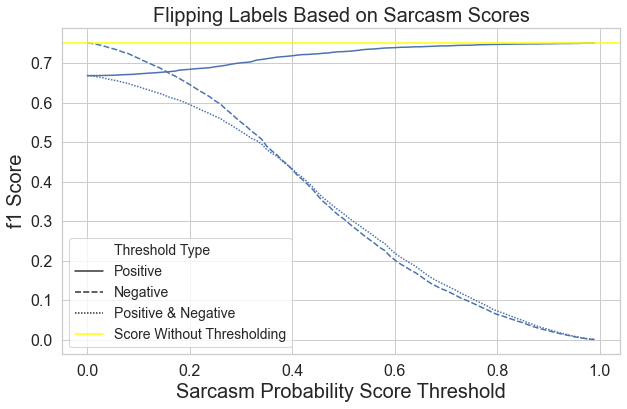

In [201]:
# Lineplot combining the f1 scores from flipping positive labels to negative and from flipping negative labels to positive based on thresholds for ...
#... sarcasm scores

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
ax = sns.lineplot(x='thresholds', y='f1_score', data = all_flip_scores, style = 'Threshold Type')
ax.axes.set_title("Flipping Labels Based on Sarcasm Scores",fontsize=20)
ax.set_xlabel("Sarcasm Probability Score Threshold",fontsize=20)
ax.set_ylabel("f1 Score",fontsize=20)
ax.tick_params(labelsize=16)
ax.axhline(0.7518, color = 'yellow', label = "Score Without Thresholding") # horizontal line at score without thresholding
#plt.ylim(0.7450,0.7575)
plt.legend(loc ='best',fontsize = 14 )
plt.savefig('f1_sarc_lineplot.png')